In [14]:
# 导入所需库
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

# 文件路径
inventory_forecast_path = '所有品类库存量预测结果.csv'
sales_forecast_path = '最终日销量预测结果.csv'
warehouse_info_path = '附件3.csv'
category_correlation_path = '附件4.csv'
attachment5_path = '附件5.csv'
allocation_result_path = '一品多仓分仓方案2.csv'

# 读取数据
inventory_forecast_df = pd.read_csv(inventory_forecast_path)
sales_forecast_df = pd.read_csv(sales_forecast_path)
warehouse_info_df = pd.read_csv(warehouse_info_path, encoding='gbk')
category_correlation_df = pd.read_csv(category_correlation_path, encoding='gbk')
attachment5_df = pd.read_csv(attachment5_path, encoding='gbk')
allocation_df = pd.read_csv(allocation_result_path)

# 数据预处理
inventory_forecast_df.rename(columns={'Unnamed: 0': '品类'}, inplace=True)

# 提取仓库容量、产能、租金成本
warehouse_capacity = warehouse_info_df.set_index('仓库')['仓容上限'].to_dict()
warehouse_output_capacity = warehouse_info_df.set_index('仓库')['产能上限'].to_dict()
warehouse_rent = warehouse_info_df.set_index('仓库')['仓租日成本'].to_dict()

# 提取库存量和销量预测
inventory_forecast = inventory_forecast_df.set_index('品类').to_dict('index')
sales_forecast = sales_forecast_df.set_index('品类').to_dict('index')

# 提取品类关联度和件型、高级品类信息
def extract_correlation(df):
    correlation_dict = {}
    for _, row in df.iterrows():
        correlation_dict[(row['品类1'], row['品类2'])] = row['关联度']
    return correlation_dict

category_correlation = extract_correlation(category_correlation_df)

# 提取高级品类和件型
category_type = attachment5_df.set_index('品类')[['高级品类', '件型']].to_dict('index')

# 粒子群优化算法参数
num_particles = 50
num_iterations = 100
w = 0.5  # 惯性权重
c1 = 1.5  # 认知权重
c2 = 1.5  # 社会权重

# 初始化分配方案
categories = inventory_forecast_df['品类'].tolist()
warehouses = list(warehouse_capacity.keys())
num_categories = len(categories)
num_warehouses = len(warehouses)

# 将仓库编号映射到整数，以便于操作
warehouse_to_index = {warehouse: idx for idx, warehouse in enumerate(warehouses)}
index_to_warehouse = {idx: warehouse for warehouse, idx in warehouse_to_index.items()}

# 初始化粒子的位置和速度
particles = [np.random.choice(range(num_warehouses), (num_categories, 3)).tolist() for _ in range(num_particles)]
velocities = [np.zeros((num_categories, 3)).tolist() for _ in range(num_particles)]

# 计算目标函数值
def calculate_cost(solution):
    mapped_solution = [[index_to_warehouse[idx] for idx in allocation] for allocation in solution]
    cost_term = 0
    utilization_term = 0
    correlation_term = 0
    
    # 计算目标函数值
    for i in range(num_categories):
        warehouses_for_category = mapped_solution[i]
        total_inventory_7 = inventory_forecast[categories[i]]['7月库存量']
        total_inventory_8 = inventory_forecast[categories[i]]['8月库存量']
        total_inventory_9 = inventory_forecast[categories[i]]['9月库存量']
        
        # 计算7、8、9月的日均出库量
        total_output_7 = sales_forecast[categories[i]].get('7月总销量', 0)
        total_output_8 = sales_forecast[categories[i]].get('8月总销量', 0)
        total_output_9 = sales_forecast[categories[i]].get('9月总销量', 0)
        num_days_7 = 31  # 7月天数
        num_days_8 = 31  # 8月天数
        num_days_9 = 30  # 9月天数
        avg_output = (total_output_7 / num_days_7 + total_output_8 / num_days_8 + total_output_9 / num_days_9) / 3
        
        for j in warehouses_for_category:
            # 计算仓租成本
            cost_term += warehouse_rent[j] * ((total_inventory_7 + total_inventory_8 + total_inventory_9) / len(warehouses_for_category))
            
            # 计算仓容和产能利用率，考虑每个月的库存量是否超出仓容
            if total_inventory_7 > warehouse_capacity[j] or total_inventory_8 > warehouse_capacity[j] or total_inventory_9 > warehouse_capacity[j]:
                utilization_term += 1e7  # 增大惩罚项
            if avg_output > warehouse_output_capacity[j]:
                utilization_term += 1e7  # 增大惩罚项
            
            # 计算利用率，鼓励高利用率
            utilization_term -= (total_inventory_7 / warehouse_capacity[j] if warehouse_capacity[j] > 0 else 0)
            utilization_term -= (total_inventory_8 / warehouse_capacity[j] if warehouse_capacity[j] > 0 else 0)
            utilization_term -= (total_inventory_9 / warehouse_capacity[j] if warehouse_capacity[j] > 0 else 0)
            utilization_term -= (avg_output / warehouse_output_capacity[j] if warehouse_output_capacity[j] > 0 else 0)
        
        # 计算关联度和集中度
        for k in range(num_categories):
            if i != k:
                if set(warehouses_for_category) & set(mapped_solution[k]):
                    correlation_term -= category_correlation.get((categories[i], categories[k]), 0)
                    # 考虑件型和高级品类
                    if category_type[categories[i]]['件型'] == category_type[categories[k]]['件型']:
                        correlation_term -= 1
                    if category_type[categories[i]]['高级品类'] == category_type[categories[k]]['高级品类']:
                        correlation_term -= 1

    return cost_term + utilization_term + correlation_term

# 初始化最优解
personal_best_positions = particles.copy()
personal_best_costs = [calculate_cost(p) for p in particles]
global_best_position = personal_best_positions[np.argmin(personal_best_costs)]
global_best_cost = min(personal_best_costs)

# 粒子群优化过程
for _ in range(num_iterations):
    for p in range(num_particles):
        # 更新速度和位置
        for i in range(num_categories):
            for j in range(3):  # 每个品类最多可存放3个仓库
                r1, r2 = random.random(), random.random()
                velocities[p][i][j] = (w * velocities[p][i][j] +
                                       c1 * r1 * (personal_best_positions[p][i][j] - particles[p][i][j]) +
                                       c2 * r2 * (global_best_position[i][j] - particles[p][i][j]))
                # 更新位置
                if random.random() < np.tanh(velocities[p][i][j]):
                    particles[p][i][j] = random.choice(range(num_warehouses))

        # 确保解的可行性：检查仓容约束并进行调整
        mapped_solution = [[index_to_warehouse[idx] for idx in allocation] for allocation in particles[p]]
        for j in warehouses:
            total_inventory_7 = sum(inventory_forecast[categories[i]]['7月库存量'] for i in range(num_categories) if j in mapped_solution[i])
            total_inventory_8 = sum(inventory_forecast[categories[i]]['8月库存量'] for i in range(num_categories) if j in mapped_solution[i])
            total_inventory_9 = sum(inventory_forecast[categories[i]]['9月库存量'] for i in range(num_categories) if j in mapped_solution[i])
            adjustment_attempts = 0
            while (total_inventory_7 > warehouse_capacity[j] or total_inventory_8 > warehouse_capacity[j] or total_inventory_9 > warehouse_capacity[j]) and adjustment_attempts < 10:
                # 随机选择一个在仓库 j 中的品类，重新分配到其他容量充足的仓库
                overstocked_categories = [i for i in range(num_categories) if j in mapped_solution[i]]
                category_to_move = random.choice(overstocked_categories)
                possible_warehouses = [w for w in warehouses if w != j and sum(inventory_forecast[categories[i]]['7月库存量'] for i in range(num_categories) if w in mapped_solution[i]) + inventory_forecast[categories[category_to_move]]['7月库存量'] <= warehouse_capacity[w]]
                
                if possible_warehouses:
                    new_warehouse = random.choice(possible_warehouses)
                    particles[p][category_to_move][mapped_solution[category_to_move].index(j)] = warehouse_to_index[new_warehouse]
                else:
                    # 若找不到符合条件的仓库，随机选择一个仓库进行重新分配
                    new_warehouse = random.choice([w for w in warehouses if w != j])
                    particles[p][category_to_move][mapped_solution[category_to_move].index(j)] = warehouse_to_index[new_warehouse]
                
                mapped_solution = [[index_to_warehouse[idx] for idx in allocation] for allocation in particles[p]]
                total_inventory_7 = sum(inventory_forecast[categories[i]]['7月库存量'] for i in range(num_categories) if j in mapped_solution[i])
                total_inventory_8 = sum(inventory_forecast[categories[i]]['8月库存量'] for i in range(num_categories) if j in mapped_solution[i])
                total_inventory_9 = sum(inventory_forecast[categories[i]]['9月库存量'] for i in range(num_categories) if j in mapped_solution[i])
                adjustment_attempts += 1

        # 计算新位置的成本
        new_cost = calculate_cost(particles[p])
        
        # 更新个人最佳位置
        if new_cost < personal_best_costs[p]:
            personal_best_positions[p] = particles[p].copy()
            personal_best_costs[p] = new_cost
        
        # 更新全局最佳位置
        if new_cost < global_best_cost:
            global_best_position = particles[p].copy()
            global_best_cost = new_cost

# 保存分仓方案为 CSV 文件
final_allocation = [[index_to_warehouse[idx] for idx in allocation] for allocation in global_best_position]
allocation_df = pd.DataFrame(list(zip(categories, *zip(*final_allocation))), columns=['品类', '仓库1', '仓库2', '仓库3'])
allocation_df.to_csv('一品多仓分仓方案2.csv', index=False)
print("分仓方案已保存到：一品多仓分仓方案2.csv")

分仓方案已保存到：一品多仓分仓方案2.csv


In [23]:
# 统计和可视化
# 计算分仓后的仓库利用率和品类分布
warehouse_inventory = {warehouse: 0 for warehouse in warehouse_capacity.keys()}
warehouse_category_count = {warehouse: 0 for warehouse in warehouse_capacity.keys()}

for _, row in allocation_df.iterrows():
    category = row['品类']
    warehouses_for_category = [row['仓库1'], row['仓库2'], row['仓库3']]
    for warehouse in warehouses_for_category:
        if pd.notna(warehouse):
            # 使用每个月的最大库存量来计算仓库利用率
            max_inventory = max(inventory_forecast[category]['7月库存量'], inventory_forecast[category]['8月库存量'], inventory_forecast[category]['9月库存量'])
            warehouse_inventory[warehouse] += max_inventory
            warehouse_category_count[warehouse] += 1

# 转换为DataFrame以便于分析
warehouse_stats_df = pd.DataFrame({
    '仓库': list(warehouse_inventory.keys()),
    '总库存量': list(warehouse_inventory.values()),
    '品类数量': list(warehouse_category_count.values()),
    '仓容上限': [warehouse_capacity[warehouse] for warehouse in warehouse_inventory.keys()]
})

# 计算利用率
warehouse_stats_df['仓库利用率'] = warehouse_stats_df['总库存量'] / warehouse_stats_df['仓容上限']

# 输出统计信息
print("仓库利用率统计信息：")
print(warehouse_stats_df[['仓库', '总库存量', '品类数量', '仓库利用率']])

# 保存统计结果
warehouse_stats_df.to_csv('仓库利用率统计结果2.csv', index=False)
print("仓库利用率统计结果已保存到：仓库利用率统计结果2.csv")




仓库利用率统计信息：
               仓库          总库存量  品类数量     仓库利用率
0      warehouse1  5.575373e+05     7  0.900871
1      warehouse2  9.261066e+05     7  0.771211
2      warehouse3  6.499113e+05     4  0.831134
3      warehouse4  8.557099e+05    12  0.769173
4      warehouse5  2.847415e+03     3  0.066236
..            ...           ...   ...       ...
135  warehouse136  2.291564e+05    13  0.756606
136  warehouse137  2.407536e+05    10  0.866407
137  warehouse138  0.000000e+00     0  0.000000
138  warehouse139  4.991493e+06    10  0.369740
139  warehouse140  4.025306e+06    12  0.898043

[140 rows x 4 columns]
仓库利用率统计结果已保存到：仓库利用率统计结果2.csv


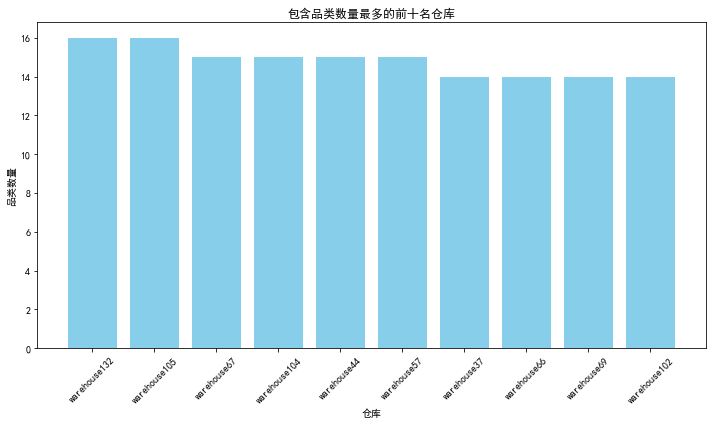

In [24]:
# 设置matplotlib绘图时可以显示中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 使得坐标轴负号显示正常
# 可视化：前十名仓库包含的品类数量柱状图
warehouse_counts = allocation_df[['仓库1', '仓库2', '仓库3']].melt(value_name='仓库').dropna()['仓库'].value_counts()
top_10_warehouses = warehouse_counts.head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_10_warehouses.index, top_10_warehouses.values, color='skyblue')
plt.xlabel('仓库')
plt.ylabel('品类数量')
plt.title('包含品类数量最多的前十名仓库')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('top_10_warehouses_bar_chart.png')
plt.show()

In [21]:
# 挑选并保存指定品类的多仓分布方案
selected_categories = [
    "category1", "category31", "category61", "category91", "category121", 
    "category151", "category181", "category211", "category241", "category271", 
    "category301", "category331"
]

# 筛选多仓分布方案
selected_allocation_df = allocation_df[allocation_df['品类'].isin(selected_categories)]

# 保存为 CSV 文件
selected_allocation_df.to_csv('指定品类多仓分布方案.csv', index=False)
print("指定品类多仓分布方案已保存到：指定品类多仓分布方案.csv")

指定品类多仓分布方案已保存到：指定品类多仓分布方案.csv
